In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from statsmodels.regression.rolling import RollingOLS

# Data

In [2]:
his_members = pd.read_excel("../data/members.xlsx", sheet_name=1)
his_members.head()

,1980-03-31,1980-06-30,1980-09-30,1980-12-31,1981-03-31,1981-06-30,1981-09-30,1981-12-31,1982-03-31,1982-06-30,...,2020-09-30,2020-12-31,2021-03-31,2021-06-30,2021-09-30,2021-12-31,2022-03-31,2022-06-30,2022-09-30,2022-10-20
0,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,...,1981718D UW Equity,2061517D UW Equity,2061517D UW Equity,2150994D UW Equity,2150994D UW Equity,1950546D US Equity,2150994D UW Equity,2150994D UW Equity,A UN Equity,A UN Equity
1,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,...,2061517D UW Equity,2078185D UN Equity,2150994D UW Equity,9990213D UN Equity,9990213D UN Equity,2150994D UW Equity,9990213D UN Equity,9990213D UN Equity,AA UN Equity,AA UN Equity
2,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,...,2078185D UN Equity,2150994D UW Equity,9990213D UN Equity,9990253D UN Equity,9990253D UN Equity,9990213D UN Equity,9990253D UN Equity,A UN Equity,AAL UW Equity,AAL UW Equity
3,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,...,2150994D UW Equity,9990213D UN Equity,9990253D UN Equity,9990527D UW Equity,9990527D UW Equity,9990253D UN Equity,9990527D UW Equity,AA UN Equity,AAP UN Equity,AAP UN Equity
4,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,...,9990213D UN Equity,9990253D UN Equity,9990620D UN Equity,A UN Equity,A UN Equity,9990527D UW Equity,A UN Equity,AAL UW Equity,ACGL UW Equity,ACGL UW Equity


In [3]:
ave_ecoc = pd.read_excel("../clean_data/ave_ecoc_0119.xlsx", index_col=0)
ave_ecoc.head()

,beta,name,DATES,GT10 Govt,rf,coe,10y_avg
0,NaN,A,1979-03-30,9.112,0.09112,NaN,NaN
1,NaN,A,1979-04-30,9.352,0.09352,NaN,NaN
2,NaN,A,1979-05-31,9.062,0.09062,NaN,NaN
3,NaN,A,1979-06-29,8.812,0.08812,NaN,NaN
4,NaN,A,1979-07-31,9.012,0.09012,NaN,NaN


In [4]:
FCFROIC_ADJ = pd.read_excel("../clean_data/FCFROIC_ADJ_yearly_0127.xlsx", index_col=0)
FCFROIC_ADJ.head()

,Year,Ticker Symbol,NYear,Cash & Short-Term Investments,Total Debt,Total Shareholder Equity,Total Invested Capital (Calculated),Operating Activities - Net Cash Flow,Capital Expenditures,FCF,SIC,ROE,avg IC,FCFROIC,FCFROIC_ADJ,avg_fcfroic_min5,avg_fcfroic_5,avg_fcfroic_7,avg_fcfroic_expanding
0,1999,A,-23,789.0,0.0,4171.0,3382.0,461.0,434.0,27.0,3826.0,NaN,3202.0,0.008432,0.008432,NaN,NaN,NaN,NaN
1,2000,A,-22,996.0,110.0,5265.0,4379.0,838.0,824.0,14.0,3826.0,NaN,3880.5,0.003608,0.003608,NaN,NaN,NaN,NaN
2,2001,A,-21,1170.0,6.0,5659.0,4495.0,1502.0,881.0,621.0,3826.0,NaN,4437.0,0.139959,0.139959,NaN,NaN,NaN,NaN
3,2002,A,-20,1844.0,1150.0,4627.0,3933.0,-498.0,301.0,-799.0,3826.0,NaN,4214.0,-0.189606,-0.189606,NaN,NaN,NaN,NaN
4,2003,A,-19,1607.0,1150.0,2824.0,2367.0,-144.0,205.0,-349.0,3826.0,NaN,3150.0,-0.110794,-0.110794,-0.02968,-0.02968,NaN,NaN


In [5]:
ave_ecoc.index = ave_ecoc["DATES"]

In [6]:
ave_ecoc["Year"] = [date.year for date in ave_ecoc["DATES"]]
ave_ecoc_yearly = ave_ecoc.drop_duplicates(subset=["name", "Year"], keep="last").copy()
ave_ecoc_yearly.head()

,beta,name,DATES,GT10 Govt,rf,coe,10y_avg,Year
DATES,,,,,,,,
1979-12-31,NaN,A,1979-12-31,10.33200,0.10332,NaN,NaN,1979
1980-12-31,NaN,A,1980-12-31,12.43200,0.12432,NaN,NaN,1980
1981-12-31,NaN,A,1981-12-31,13.98200,0.13982,NaN,NaN,1981
1982-12-31,NaN,A,1982-12-31,10.47200,0.10472,NaN,NaN,1982
1983-12-30,NaN,A,1983-12-30,11.80098,0.11801,NaN,NaN,1983


In [7]:
ave_ecoc_yearly = ave_ecoc_yearly.dropna()

In [8]:
ave_ecoc_yearly["Ticker Symbol"] = ave_ecoc_yearly["name"]

In [9]:
all_data = FCFROIC_ADJ.merge(ave_ecoc_yearly, on=["Ticker Symbol", "Year"], how="outer")
all_data

,Year,Ticker Symbol,NYear,Cash & Short-Term Investments,Total Debt,Total Shareholder Equity,Total Invested Capital (Calculated),Operating Activities - Net Cash Flow,Capital Expenditures,FCF,...,avg_fcfroic_5,avg_fcfroic_7,avg_fcfroic_expanding,beta,name,DATES,GT10 Govt,rf,coe,10y_avg
0,1999,A,-23.0,789.0,0.0,4171.0,3382.0,461.0,434.0,27.0,...,NaN,NaN,NaN,1.439147,A,1999-12-31,6.442000,0.064420,0.150769,0.146087
1,2000,A,-22.0,996.0,110.0,5265.0,4379.0,838.0,824.0,14.0,...,NaN,NaN,NaN,1.566783,A,2000-12-29,5.111638,0.051116,0.145123,0.140849
2,2001,A,-21.0,1170.0,6.0,5659.0,4495.0,1502.0,881.0,621.0,...,NaN,NaN,NaN,1.955837,A,2001-12-31,5.051019,0.050510,0.167860,0.137815
3,2002,A,-20.0,1844.0,1150.0,4627.0,3933.0,-498.0,301.0,-799.0,...,NaN,NaN,NaN,2.061950,A,2002-12-31,3.815700,0.038157,0.161874,0.137857
4,2003,A,-19.0,1607.0,1150.0,2824.0,2367.0,-144.0,205.0,-349.0,...,-0.02968,NaN,NaN,2.213983,A,2003-12-31,4.247506,0.042475,0.175314,0.139912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47806,2022,XLNX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.029830,XLNX,2022-01-31,1.778463,0.017785,0.079574,0.089531
47807,2010,XTO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.715889,XTO,2010-04-30,3.655119,0.036551,0.079505,0.092355
47808,2021,ZG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.603667,ZG,2021-12-31,1.511821,0.015118,0.111338,0.099659
47809,2022,ZG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.570586,ZG,2022-03-31,2.340687,0.023407,0.117642,0.100409


In [10]:
all_data.to_excel("../clean_data/all_data_0127.xlsx")

In [51]:
his_members

,1980-03-31,1980-06-30,1980-09-30,1980-12-31,1981-03-31,1981-06-30,1981-09-30,1981-12-31,1982-03-31,1982-06-30,...,2020-09-30,2020-12-31,2021-03-31,2021-06-30,2021-09-30,2021-12-31,2022-03-31,2022-06-30,2022-09-30,2022-10-20
0,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,...,1981718D UW Equity,2061517D UW Equity,2061517D UW Equity,2150994D UW Equity,2150994D UW Equity,1950546D US Equity,2150994D UW Equity,2150994D UW Equity,A UN Equity,A UN Equity
1,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,...,2061517D UW Equity,2078185D UN Equity,2150994D UW Equity,9990213D UN Equity,9990213D UN Equity,2150994D UW Equity,9990213D UN Equity,9990213D UN Equity,AA UN Equity,AA UN Equity
2,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,...,2078185D UN Equity,2150994D UW Equity,9990213D UN Equity,9990253D UN Equity,9990253D UN Equity,9990213D UN Equity,9990253D UN Equity,A UN Equity,AAL UW Equity,AAL UW Equity
3,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,...,2150994D UW Equity,9990213D UN Equity,9990253D UN Equity,9990527D UW Equity,9990527D UW Equity,9990253D UN Equity,9990527D UW Equity,AA UN Equity,AAP UN Equity,AAP UN Equity
4,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,...,9990213D UN Equity,9990253D UN Equity,9990620D UN Equity,A UN Equity,A UN Equity,9990527D UW Equity,A UN Equity,AAL UW Equity,ACGL UW Equity,ACGL UW Equity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,ZBH UN Equity,NaN,NaN,ZION UW Equity,NaN,ZBRA UW Equity,NaN,NaN
703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,ZBRA UW Equity,NaN,NaN,ZNGA UW Equity,NaN,ZG UW Equity,NaN,NaN
704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,ZG UW Equity,NaN,NaN,NaN,NaN,ZION UW Equity,NaN,NaN
705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,ZION UW Equity,NaN,NaN,NaN,NaN,ZM UW Equity,NaN,NaN


In [11]:
q_ls = his_members.columns
q_ls_d = pd.to_datetime(q_ls)

ls = []
numbers = []
high_q_rate = []
low_q_rate = []
high_q_ls = []
low_q_ls = []

for i in range(his_members.shape[1]-1):
    m = his_members.iloc[:, i].dropna()
    quarter = datetime.strptime(m.name, "%Y-%m-%d")
    g = all_data[all_data["Year"] == quarter.year]

    m = m.str.extract(r'(\w+)')[0].values
    # print(m)
    subset = g[g["Ticker Symbol"].isin(m)]
    subset["Quarter"] = quarter
    number = subset.shape[0]
    numbers.append(number)
    
    ls.append(subset)
    

quality = pd.concat(ls, ignore_index=True)
quality

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,Year,Ticker Symbol,NYear,Cash & Short-Term Investments,Total Debt,Total Shareholder Equity,Total Invested Capital (Calculated),Operating Activities - Net Cash Flow,Capital Expenditures,FCF,...,avg_fcfroic_7,avg_fcfroic_expanding,beta,name,DATES,GT10 Govt,rf,coe,10y_avg,Quarter
0,1980,ADM,-42.0,125.745,228.867,766.971,870.093,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,1980-03-31
1,1980,AEE,-42.0,53.816,1621.641,1436.944,3004.769,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,1980-03-31
2,1980,AEP,-42.0,80.460,5681.418,3969.701,9570.659,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,1980-03-31
3,1980,AFG,-42.0,180.000,586.500,1395.200,1801.700,1369.55,124.5,1245.05,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,1980-03-31
4,1980,ALE,-42.0,1.004,414.959,336.584,750.539,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,1980-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67285,2022,RPM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.922073,RPM,2022-03-31,2.340687,0.023407,0.078731,0.098036,2022-09-30
67286,2022,SJM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.262041,SJM,2022-03-31,2.340687,0.023407,0.039129,0.048526,2022-09-30
67287,2022,STE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.694922,STE,2022-03-31,2.340687,0.023407,0.065102,0.078105,2022-09-30
67288,2022,UHAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.948047,UHAL,2022-03-31,2.340687,0.023407,0.080290,0.087239,2022-09-30


In [11]:
q_ls = his_members.columns
q_ls

Index(['1980-03-31', '1980-06-30', '1980-09-30', '1980-12-31', '1981-03-31',
       '1981-06-30', '1981-09-30', '1981-12-31', '1982-03-31', '1982-06-30',
       ...
       '2020-09-30', '2020-12-31', '2021-03-31', '2021-06-30', '2021-09-30',
       '2021-12-31', '2022-03-31', '2022-06-30', '2022-09-30', '2022-10-20'],
      dtype='object', length=172)

In [12]:
quality["10y_ind"] = np.nan
quality.loc[(quality["avg_fcfroic_min5"] >=
            quality["10y_avg"]), "10y_ind"] = 1
quality.loc[(quality["avg_fcfroic_min5"] <
            quality["10y_avg"]), "10y_ind"] = 0

quality["7y_ind"] = np.nan
quality.loc[(quality["avg_fcfroic_7"] >=
            quality["10y_avg"]), "7y_ind"] = 1
quality.loc[(quality["avg_fcfroic_7"] <
            quality["10y_avg"]), "7y_ind"] = 0

quality["5y_ind"] = np.nan
quality.loc[(quality["avg_fcfroic_5"] >=
            quality["10y_avg"]), "5y_ind"] = 1
quality.loc[(quality["avg_fcfroic_5"] <
            quality["10y_avg"]), "5y_ind"] = 0

quality.to_excel("../clean_data/quantity_yearly_0127.xlsx")

In [13]:
low_q_num = quality[quality["10y_ind"] == 0].groupby("Quarter").count()["10y_ind"]
high_q_num = quality[quality["10y_ind"] == 1].groupby("Quarter").count()["10y_ind"]
num = quality.groupby("Quarter").count()["Ticker Symbol"]

In [26]:
quality["5y_ind"].dropna()

8006     1.0
8297     1.0
8588     1.0
8879     1.0
8966     0.0
        ... 
67206    1.0
67237    0.0
67247    0.0
67251    0.0
67260    0.0
Name: 5y_ind, Length: 33057, dtype: float64

In [34]:
quality.groupby("Quarter").count().to_excel("../clean_data/quarterly_numbers.xlsx")

In [14]:
num_all = pd.DataFrame()
num_all["high_q_num"] = high_q_num
num_all["low_q_num"] = low_q_num
num_all["total_num"] = num

In [15]:
num_all.to_excel("../clean_data/numbers_of_stocks_in_buckets_0127.xlsx")

In [16]:
close_price = pd.read_excel("../data/stk_ret_value.xlsx")
close_price.head()

,Ticker,Monthly Calendar Date,Monthly Price Date,Monthly Market Capitalization,Monthly Total Return
0,ACF,1970-01-30,1970-01-30,261601.375,-0.053571
1,ACF,1970-02-27,1970-02-27,271473.125,0.051272
2,ACF,1970-03-31,1970-03-31,277819.250,0.023377
3,ACF,1970-04-30,1970-04-30,256665.500,-0.076142
4,ACF,1970-05-29,1970-05-29,217178.500,-0.139744


In [17]:
close_price["quarterly_ret"] = (
    close_price["Monthly Total Return"] + 1).rolling(3).apply(np.prod, raw=True) - 1

# classification

In [78]:
FCFROIC_ADJ

,Year,Ticker Symbol,NYear,Cash & Short-Term Investments,Total Debt,Total Shareholder Equity,Total Invested Capital (Calculated),Operating Activities - Net Cash Flow,Capital Expenditures,FCF,SIC,ROE,avg IC,FCFROIC,FCFROIC_ADJ,avg_fcfroic_min1,avg_fcfroic_min5,avg_fcfroic_expanding
0,1999,A,-23,789.000,0.0,4171.000,3382.000,461.000,434.000,27.000,3826.0,NaN,3202.0000,0.008432,0.008432,0.008432,NaN,NaN
1,2000,A,-22,996.000,110.0,5265.000,4379.000,838.000,824.000,14.000,3826.0,NaN,3880.5000,0.003608,0.003608,0.006020,NaN,NaN
2,2001,A,-21,1170.000,6.0,5659.000,4495.000,1502.000,881.000,621.000,3826.0,NaN,4437.0000,0.139959,0.139959,0.050666,NaN,NaN
3,2002,A,-20,1844.000,1150.0,4627.000,3933.000,-498.000,301.000,-799.000,3826.0,NaN,4214.0000,-0.189606,-0.189606,-0.009402,NaN,NaN
4,2003,A,-19,1607.000,1150.0,2824.000,2367.000,-144.000,205.000,-349.000,3826.0,NaN,3150.0000,-0.110794,-0.110794,-0.029680,-0.029680,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44741,2022,ZTS,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.168887,0.168887,0.153209
44742,2012,ZU,-10,239.202,0.0,206.487,-32.715,16.283,7.858,8.425,5961.0,NaN,-24.1625,-0.348681,1.000000,-0.348681,NaN,NaN
44743,2013,ZU,-9,308.103,0.0,242.203,-65.900,73.120,19.606,53.514,5961.0,0.079499,-49.3075,-1.085312,1.000000,-0.716996,NaN,NaN
44744,2014,ZU,-8,373.820,0.0,275.963,-97.857,130.014,67.757,62.257,5961.0,0.040561,-81.8785,-0.760358,1.000000,-0.731450,NaN,NaN


In [29]:
fcfroic_grouped = FCFROIC_ADJ.groupby("Year")

In [16]:
rate = pd.DataFrame()
rate["high_num"] = high_q_ls
rate["low_num"] = low_q_ls
rate["high_q"] = high_q_rate
rate["low_q"] = low_q_rate
rate.to_excel("../clean_data/summarized_rate_1218.xlsx")

In [22]:
quality.to_excel("../clean_data/quantity_0112.xlsx")

In [21]:
high_q = quality[quality["10y_ind"] == 1]
low_q = quality[quality["10y_ind"] == 0]

In [22]:
quality_grouped = quality.groupby(["Fiscal Year", "Fiscal Quarter"])
quality_grouped.mean().to_excel("../clean_data/summarized_data.xlsx")

In [23]:
quality_grouped = high_q.groupby(["Fiscal Year", "Fiscal Quarter"])
quality_grouped.mean().to_excel("../clean_data/summarized_data_high.xlsx")

quality_grouped = low_q.groupby(["Fiscal Year", "Fiscal Quarter"])
quality_grouped.mean().to_excel("../clean_data/summarized_data_low.xlsx")


In [20]:
date_idx = ave_ecoc.index.drop_duplicates()
date_idx = date_idx.sort_values()

def closest_p(dt):
    # datetime.strptime(dt, "%Y-%m-%d")
    return date_idx[date_idx >= dt][0]

## cal rolling return

In [31]:
def cal_rolling_ret(close_price):
    close_price["1y_rollingret"] = (
        close_price["Monthly Total Return"] + 1).rolling(12).apply(np.prod, raw=True) - 1
    close_price["3y_rollingret"] = (
        close_price["Monthly Total Return"] + 1).rolling(36).apply(np.prod, raw=True) - 1
    close_price["5y_rollingret"] = (
        close_price["Monthly Total Return"] + 1).rolling(60).apply(np.prod, raw=True) - 1
    return close_price

In [52]:
close_price

,Ticker,Monthly Calendar Date,Monthly Price,Monthly Price Date,Monthly Previous Price,Monthly Total Return,quarterly_ret
0,ACF,1961-01-31,50.250,1961-01-31,38.000,0.322368,NaN
1,ACF,1961-02-28,50.375,1961-02-28,50.250,0.014743,NaN
2,ACF,1961-03-30,54.750,1961-03-30,50.375,0.086849,0.458403
3,ACF,1961-04-28,56.000,1961-04-28,54.750,0.022831,0.128052
4,ACF,1961-05-31,59.750,1961-05-31,56.000,0.078315,0.198722
...,...,...,...,...,...,...,...
656935,TSLA,2021-11-30,1144.760,2021-11-30,1114.000,0.027612,0.555972
656936,TSLA,2021-12-31,1056.780,2021-12-31,1144.760,-0.076855,0.362743
656937,TSLA,2022-01-31,936.720,2022-01-31,1056.780,-0.113609,-0.159138
656938,TSLA,2022-02-28,870.430,2022-02-28,936.720,-0.070768,-0.239640


In [57]:
quality.Quarter.drop_duplicates()

0       1980-03-31
182     1980-06-30
364     1980-09-30
546     1980-12-31
728     1981-03-31
           ...    
63844   2021-09-30
64530   2021-12-31
65217   2022-03-31
65902   2022-06-30
66597   2022-09-30
Name: Quarter, Length: 171, dtype: datetime64[ns]

In [19]:
close_price["Month"] = pd.to_datetime(close_price["Monthly Calendar Date"]).dt.to_period('M')

In [20]:
quality["Month"] = pd.to_datetime(quality["Quarter"]).dt.to_period('M')

In [21]:
quality_all = quality.merge(close_price[["Ticker", "Month", "quarterly_ret", "Monthly Market Capitalization"]], left_on=[
                            "Ticker Symbol", "Month"], right_on=["Ticker", "Month"])
quality_all

,Year,Ticker Symbol,NYear,Cash & Short-Term Investments,Total Debt,Total Shareholder Equity,Total Invested Capital (Calculated),Operating Activities - Net Cash Flow,Capital Expenditures,FCF,...,coe,10y_avg,Quarter,10y_ind,7y_ind,5y_ind,Month,Ticker,quarterly_ret,Monthly Market Capitalization
0,1980,ADM,-42.0,125.745,228.867,766.971,870.093,NaN,NaN,NaN,...,NaN,NaN,1980-03-31,NaN,NaN,NaN,1980-03,ADM,-0.071600,1.109848e+06
1,1980,AEE,-42.0,53.816,1621.641,1436.944,3004.769,NaN,NaN,NaN,...,NaN,NaN,1980-03-31,NaN,NaN,NaN,1980-03,AEE,-0.137398,5.879700e+05
2,1980,AEE,-42.0,53.816,1621.641,1436.944,3004.769,NaN,NaN,NaN,...,NaN,NaN,1980-03-31,NaN,NaN,NaN,1980-03,AEE,-0.190476,1.075462e+04
3,1980,AEP,-42.0,80.460,5681.418,3969.701,9570.659,NaN,NaN,NaN,...,NaN,NaN,1980-03-31,NaN,NaN,NaN,1980-03,AEP,-0.150627,1.941456e+06
4,1980,AFG,-42.0,180.000,586.500,1395.200,1801.700,1369.55,124.5,1245.05,...,NaN,NaN,1980-03-31,NaN,NaN,NaN,1980-03,AFG,-0.313514,3.675698e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66794,2022,RPM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.078731,0.098036,2022-03-31,NaN,NaN,NaN,2022-03,RPM,-0.190146,1.056081e+07
66795,2022,SJM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.039129,0.048526,2022-03-31,NaN,NaN,NaN,2022-03,SJM,0.004370,1.468630e+07
66796,2022,STE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.065102,0.078105,2022-03-31,NaN,NaN,NaN,2022-03,STE,-0.004874,2.420770e+07
66797,2022,UHAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.080290,0.087239,2022-03-31,NaN,NaN,NaN,2022-03,UHAL,-0.178029,1.170480e+07


In [22]:
quality_all.to_excel("../clean_data/quality_0127.xlsx")

## numbers

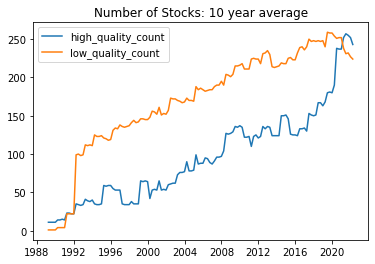

In [48]:
low_avg_count = quality_all[quality_all["10y_ind"]== 0].groupby("Quarter").count()["Ticker"]
high_avg_count = quality_all[quality_all["10y_ind"] == 1].groupby("Quarter").count()[
    "Ticker"]

avg_ret = pd.merge(high_avg_count, low_avg_count,
                   left_index=True, right_index=True)
avg_ret.columns = ["high_quality_count", "low_quality_count"]
plt.plot(avg_ret)
plt.legend(avg_ret.columns)
plt.title("Number of Stocks: 10 year average")
plt.savefig("../plot/avg_ret_10.png")

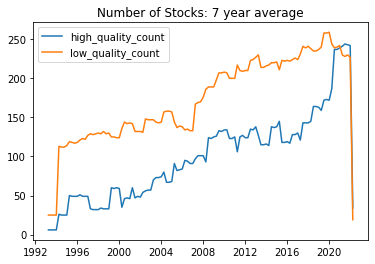

In [47]:
low_avg_count = quality_all[quality_all["7y_ind"]== 0].groupby("Quarter").count()["Ticker"]
high_avg_count = quality_all[quality_all["7y_ind"] == 1].groupby("Quarter").count()[
    "Ticker"]

avg_ret = pd.merge(high_avg_count, low_avg_count,
                   left_index=True, right_index=True)
avg_ret.columns = ["high_quality_count", "low_quality_count"]
plt.plot(avg_ret)
plt.legend(avg_ret.columns)
plt.title("Number of Stocks: 7 year average")
plt.savefig("../plot/avg_ret.png")

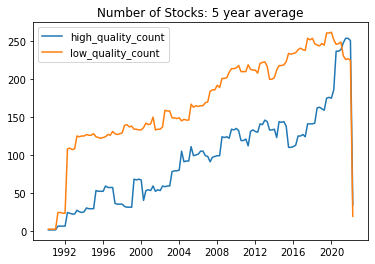

In [50]:
low_avg_count = quality_all[quality_all["5y_ind"]== 0].groupby("Quarter").count()["Ticker"]
high_avg_count = quality_all[quality_all["5y_ind"] == 1].groupby("Quarter").count()[
    "Ticker"]

avg_ret = pd.merge(high_avg_count, low_avg_count,
                   left_index=True, right_index=True)
avg_ret.columns = ["high_quality_count", "low_quality_count"]
plt.plot(avg_ret)
plt.legend(avg_ret.columns)
plt.title("Number of Stocks: 5 year average")
plt.savefig("../plot/avg_ret.png")

In [97]:
df = quality_all.copy()

In [36]:

def get_q_ret(df):
    grouped = df.groupby("Quarter")
    q_ls = df["Quarter"].drop_duplicates()
    quarterly_ret = pd.DataFrame(index=q_ls, columns=["equal_weighted_ret", "value_weighted_ret"])
    for q, group in grouped:
        weight = group['Monthly Market Capitalization']/group['Monthly Market Capitalization'].sum()
        ret = (group["quarterly_ret"] * weight).sum()
        quarterly_ret.loc[q, "equal_weighted_ret"] = group["quarterly_ret"].mean()
        quarterly_ret.loc[q, "value_weighted_ret"] = ret
    return quarterly_ret

low_ret = get_q_ret(quality_all[quality_all["10y_ind"] == 0])
high_ret = get_q_ret(quality_all[quality_all["10y_ind"] == 1])
total_ret = get_q_ret(quality_all)
low_ret.to_excel("../clean_data/low_ret_0126.xlsx")
high_ret.to_excel("../clean_data/high_ret_0126.xlsx")
total_ret.to_excel("../clean_data/total_ret_0126.xlsx")

In [37]:
low_avg_ret = quality_all[quality_all["10y_ind"] == 0].groupby("Quarter").mean()[
    "quarterly_ret"]
high_avg_ret = quality_all[quality_all["10y_ind"] == 1].groupby("Quarter").mean()[
    "quarterly_ret"]
all_avg_ret = quality_all.groupby("Quarter").mean()[
    "quarterly_ret"]
avg_ret = pd.merge(high_avg_ret, low_avg_ret,
                   left_index=True, right_index=True)
avg_ret = pd.merge(avg_ret, all_avg_ret, left_index=True, right_index=True)
avg_ret.columns = ["high_quality_avg_ret", "low_quality_avg_ret", "all_ret"]
ave_ret_cum = (avg_ret + 1).cumprod()
ave_ret_cum.columns = ["high_quality_cumprod", "low_quality_cumprod", "all_ret_cumprod"]
avg_ret_all = pd.merge(avg_ret, ave_ret_cum, left_index=True, right_index=True)
avg_ret_all.to_excel("../clean_data/avg_ret_all_0119.xlsx")

In [38]:
avg_ret.to_excel("../clean_data/quarterly_return_0119.xlsx")

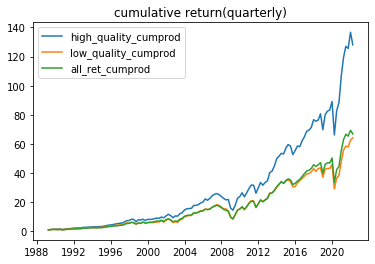

In [39]:
# ave_ret_cum.plot()
plt.plot(ave_ret_cum)
plt.legend(ave_ret_cum.columns)
plt.title("cumulative return(quarterly)")
plt.savefig("../plot/cumulative return.png")

In [45]:
avg_ret.merge(ave_ret_cum, left_index=True, right_index=True).to_excel("../clean_data/new_ret_0112.xlsx")

In [46]:
ave_ret_cum

,high_quality_cumprod,low_quality_cumprod
Quarter,,
1989-03-31,1.445483,1.050712
1989-06-30,1.738318,1.144526
1990-12-31,2.055520,1.258234
1991-09-30,2.281069,1.320232
1991-12-31,2.688360,1.427520
...,...,...
2021-03-31,32.244481,12.621449
2021-06-30,34.271676,13.230447
2021-09-30,33.871427,13.122665


In [40]:
def summary_stat(df, annual_factor, q=0.05):
    '''summary assets' mean return, voaltility(stdev) and sharpe ratio'''
    result = pd.DataFrame()
    result["mean"] = df.mean() * annual_factor
    result["volatility"] = df.std() * np.sqrt(annual_factor)
    result["Sharpe Ratio"] = result["mean"]/result["volatility"]

    result["VaR"] = df.quantile(q)
    return result

summary_stat(avg_ret, annual_factor=4)

,mean,volatility,Sharpe Ratio,VaR
high_quality_avg_ret,0.165734,0.184429,0.898633,-0.121742
low_quality_avg_ret,0.151890,0.221496,0.685745,-0.138726
all_ret,0.147289,0.192870,0.763671,-0.137049


In [ ]:
quality_all

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Ticker Symbol,FCFROIC,ROA,ROE,FCFROIC_ADJ,filtered,...,rf,coe,cost of equity,10y_avg,ind,close_date,Monthly Price Date,Ticker,q_ret_x,q_ret_y
0,9299,1987-12-31,1987,4.0,R,-0.154917,-0.004939,-0.020139,-0.154917,-0.154917,...,0.057656,0.136393,0.136393,0.155711,0,1987-12-31,1987-12-31,R,-0.273973,-0.273973
1,9299,1987-12-31,1987,4.0,R,-0.154917,-0.004939,-0.020139,-0.154917,-0.154917,...,0.057656,0.136393,0.136393,0.155711,0,1987-12-31,1987-12-31,R,-0.772727,-0.772727
2,10614,1987-12-31,1987,4.0,GL,0.225736,-0.024744,NaN,0.225736,0.225736,...,0.057656,0.117010,0.117010,0.138733,0,1987-12-31,1987-12-31,GL,-0.200000,-0.200000
3,9299,1988-03-31,1988,1.0,R,-0.044759,-0.005749,-0.023584,-0.044759,-0.044759,...,0.062058,0.135672,0.135672,0.154766,0,1988-03-31,1988-03-31,R,0.099057,0.099057
4,9299,1988-03-31,1988,1.0,R,-0.044759,-0.005749,-0.023584,-0.044759,-0.044759,...,0.062058,0.135672,0.135672,0.154766,0,1988-03-31,1988-03-31,R,-0.300000,-0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31958,199356,2021-12-31,2021,4.0,TRIP,0.031386,-0.052163,-0.151611,0.031386,0.031386,...,0.000507,0.083073,0.083073,0.054006,1,2021-12-31,2021-12-31,TRIP,-0.194682,-0.194682
31959,260774,2021-12-31,2021,4.0,CBRE,0.183715,0.049038,0.118106,0.183715,0.183715,...,0.000507,0.084284,0.084284,0.114787,0,2021-12-31,2021-12-31,CBRE,0.114523,0.114523
31960,315318,2021-12-31,2021,4.0,ESI,0.062421,-0.024881,-0.051197,0.062421,0.062421,...,0.000507,0.081897,0.081897,0.121450,0,2021-12-31,2021-12-31,ESI,0.119926,0.119926
31961,316056,2021-12-31,2021,4.0,ALLE,0.202411,-0.039820,-0.150675,0.202411,0.202411,...,0.000507,0.062225,0.062225,0.050331,0,2021-12-31,2021-12-31,ALLE,0.001967,0.001967


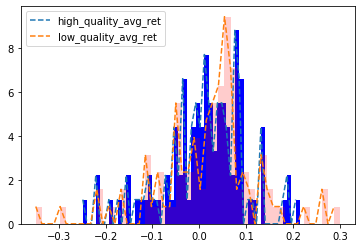

In [46]:
n1, bins1, patches1 = plt.hist(
    avg_ret.iloc[:, 0], bins=50, density=True, color='b', alpha=1)
n2, bins2, patches2 = plt.hist(
    avg_ret.iloc[:, 1], bins=50, density=True, color='r', alpha=0.2)

plt.plot(bins1[:-1], n1, '--')
plt.plot(bins2[:-1], n2, '--')
plt.legend(avg_ret.columns)

In [48]:
avg_ret.mean()/avg_ret.std()

high_quality_avg_ret    0.127573
low_quality_avg_ret     0.196831
dtype: float64

In [78]:
quality_all.columns

Index(['Global Company Key', 'Data Date', 'Fiscal Year', 'Fiscal Quarter',
       'Ticker Symbol', 'FCFROIC', 'ROA', 'ROE', 'FCFROIC_ADJ', 'filtered',
       'avg_fcfroic', 'avg_fcfroic_ajd', 'beta', 'TMBIDYTM', 'rf', 'coe',
       'cost of equity', '10y_avg', '10y_ind', 'ind', 'close_date',
       'Monthly Price Date', 'Ticker', 'Monthly Price'],
      dtype='object')

In [22]:
high_q_group = quality_all[quality_all["10y_ind"] == 1].groupby("Fiscal Year")
low_q_group = quality_all[quality_all["10y_ind"] == 0].groupby("Fiscal Year")
high_dict = {}
for g in high_q_group:
    y = g[0]
    g = g[1]
    high_dict[y] = g["Ticker"].drop_duplicates()

In [23]:
close_price = close_price.drop_duplicates(
    subset=["Ticker", "Monthly Calendar Date"])
close_price.sort_values(by=["Ticker", "Monthly Calendar Date"], inplace=True)

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [24]:
close_price

,Ticker,Monthly Calendar Date,Monthly Price,Monthly Price Date,Monthly Previous Price,Monthly Total Return,q_pre_p,q_ret
8114,A,1961-01-31,49.125,1961-01-31,43.500,0.129310,23.375,1.101604
8115,A,1961-02-28,54.125,1961-02-28,49.125,0.101781,23.500,1.303191
8116,A,1961-03-30,54.000,1961-03-30,54.125,0.007103,27.000,1.000000
8117,A,1961-04-28,60.625,1961-04-28,54.000,0.122685,49.125,0.234097
8118,A,1961-05-31,62.375,1961-05-31,60.625,0.037113,54.125,0.152425
...,...,...,...,...,...,...,...,...
58488,ZU,2015-05-29,13.225,2015-05-29,12.465,0.060971,14.010,-0.056031
58489,ZU,2015-06-30,13.040,2015-06-30,13.225,-0.013989,12.990,0.003849
58490,ZU,2015-07-31,13.210,2015-07-31,13.040,0.013037,12.465,0.059767
58491,ZU,2015-08-31,17.750,2015-08-31,13.210,0.343679,13.225,0.342155


In [25]:
close_price_u = rolling_ret
quality_all = pd.merge(quality, close_price_u, left_on=["close_date", "Ticker Symbol"],
                       right_on=["Monthly Price Date", "Ticker"], how="inner")
quality_all

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Ticker Symbol,FCFROIC_cal,avg_fcfroic,avg_fcfroic_expanding,beta,GT10 Govt,...,10y_avg,10y_ind,ind,close_date,Monthly Price Date,Monthly Total Return,Ticker,1y_rollingret,3y_rollingret,5y_rollingret
0,1161,1994-06-30,1994,2.0,AMD,-0.288028,NaN,NaN,1.622068,7.201381,...,0.202009,0,0,1994-06-30,1994-06-30,-0.074074,AMD,0.036269,1.083333,1.564103
1,1209,1994-06-30,1994,3.0,APD,0.051280,NaN,NaN,1.232546,7.201381,...,0.156832,0,0,1994-06-30,1994-06-30,0.008707,APD,0.103206,0.343975,1.093011
2,1246,1994-06-30,1994,3.0,IKN,0.029201,NaN,NaN,1.034703,7.201381,...,0.148176,0,0,1994-06-30,1994-06-30,-0.015086,IKN,0.194500,0.942477,1.147874
3,1380,1994-06-30,1994,2.0,HES,0.060205,NaN,NaN,0.455329,7.201381,...,0.140378,0,0,1994-06-30,1994-06-30,-0.002005,HES,0.017765,-0.004399,0.412299
4,1678,1994-06-30,1994,2.0,APA,-0.099357,NaN,NaN,0.906926,7.201381,...,0.152366,0,0,1994-06-30,1994-06-30,0.020991,APA,0.006214,0.952022,1.487586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32127,192255,2022-03-31,2022,1.0,ACHC,0.006485,-0.002705,-0.006037,1.460231,2.340687,...,0.066162,0,0,2022-03-31,2022-03-31,0.155528,ACHC,0.146832,1.235756,0.502982
32128,199356,2022-03-31,2022,1.0,TRIP,0.073770,0.196274,0.190735,1.320309,2.340687,...,0.115826,1,0,2022-03-31,2022-03-31,0.066038,TRIP,-0.495817,-0.407879,-0.294147
32129,260774,2022-03-31,2022,1.0,CBRE,-0.037810,0.014973,0.021440,1.417245,2.340687,...,0.139234,0,0,2022-03-31,2022-03-31,-0.055034,CBRE,0.156870,0.850758,1.630641
32130,315318,2022-03-31,2022,1.0,ESI,-0.003622,NaN,NaN,1.406285,2.340687,...,0.130204,0,0,2022-03-31,2022-03-31,-0.109032,ESI,0.211757,1.208144,0.712923


In [26]:
quality_all.to_excel("../clean_data/quality_n_1202.xlsx")

In [45]:
high_q = quality_all[quality_all["10y_ind"] == 1]
low_q = quality_all[quality_all["10y_ind"] == 0]
# high_q.to_excel("../clean_data/highq_bucket_0119.xlsx")
# low_q.to_excel("../clean_data/lowq_bucket_0119.xlsx")

In [46]:
high_q_fcfroic = high_q.groupby("Quarter").mean()[["avg_fcfroic_min5"]]
low_q_fcfroic = low_q.groupby("Quarter").mean()[["avg_fcfroic_min5"]]
fcfroic_buckets = quality_all.groupby("Quarter").mean()[["avg_fcfroic_min5"]]
fcfroic_buckets = fcfroic_buckets.merge(high_q_fcfroic, left_index=True, right_index=True)
fcfroic_buckets = fcfroic_buckets.merge(low_q_fcfroic, left_index=True, right_index=True)
fcfroic_buckets.columns = ["ALL", "High Quality", "Low Qualiry"]
fcfroic_buckets.to_excel("../clean_data/fcfroic_buckets_0126_10.xlsx")

In [38]:
low_q.groupby("Quarter").mean()["avg_fcfroic"]

Quarter
1996-09-30   -0.030698
1996-12-31   -0.030698
1997-03-31    0.030968
1997-06-30    0.030968
1997-09-30    0.030968
                ...   
2021-03-31   -0.021051
2021-06-30   -0.013344
2021-09-30   -0.013039
2021-12-31   -0.012602
2022-03-31    0.001889
Name: avg_fcfroic, Length: 76, dtype: float64

In [94]:
rolling_ret.index = rolling_ret["Monthly Price Date"]
rolling_ret["year"] = [str(date.year) for date in rolling_ret["Monthly Price Date"]]

In [95]:
rolling_ret

,Monthly Price Date,Monthly Total Return,Ticker,1y_rollingret,3y_rollingret,5y_rollingret,year
Monthly Price Date,,,,,,,
1961-01-31,1961-01-31,0.129310,A,NaN,NaN,NaN,1961
1961-02-28,1961-02-28,0.101781,A,NaN,NaN,NaN,1961
1961-03-30,1961-03-30,0.007103,A,NaN,NaN,NaN,1961
1961-04-28,1961-04-28,0.122685,A,NaN,NaN,NaN,1961
1961-05-31,1961-05-31,0.037113,A,NaN,NaN,NaN,1961
...,...,...,...,...,...,...,...
2015-05-29,2015-05-29,0.060971,ZU,-0.619205,NaN,NaN,2015
2015-06-30,2015-06-30,-0.013989,ZU,-0.681563,NaN,NaN,2015
2015-07-31,2015-07-31,0.013037,ZU,-0.618429,NaN,NaN,2015


In [98]:
high_q_group = high_q.groupby("Year")
ls = []
for g in high_q_group:
    year = g[0]
    ticker = g[1]["Ticker Symbol"].drop_duplicates().values
    roll_ret = rolling_ret[(rolling_ret["year"] == str(year)) & (rolling_ret["Ticker"].isin(ticker))].groupby("Ticker").mean()
    roll_ret["Ticker"] = roll_ret.index
    roll_ret["Year"] = year
    ls.append(roll_ret)
high_ret_n = pd.concat(ls, ignore_index=True)

In [99]:
high_ret_n.to_excel("../clean_data/highq_bucket_rolling_is_1223.xlsx")

In [39]:
high_ret_n

,Monthly Total Return,1y_rollingret,3y_rollingret,5y_rollingret,Ticker,Year
0,0.001375,0.152641,0.462701,0.945171,SON,1996
1,0.019240,0.306904,0.899389,0.914488,BMS,1997
2,0.033766,0.468860,1.332953,2.864549,CSL,1997
3,0.056985,0.700036,0.851092,1.597455,HNI,1997
4,0.041839,0.207905,0.744442,1.307472,ITT,1997
...,...,...,...,...,...,...
2849,-0.057152,0.152743,0.308407,1.096407,WAT,2022
2850,-0.082450,-0.198656,0.117296,-0.290549,WDC,2022
2851,-0.000463,0.189968,1.204879,1.295989,WSO,2022
2852,0.084902,0.088444,-0.303083,1.882259,WWE,2022


In [34]:
low_q_group = low_q.groupby("Year")
ls = []
for g in low_q_group:
    year = g[0]
    ticker = g[1]["Ticker Symbol"].values
    high_ticker = set(high_ret_n[high_ret_n["Year"] == year].Ticker.values)
    ticker = list(set(ticker) - high_ticker)
    roll_ret = rolling_ret[(rolling_ret["year"] == str(year)) & (
        rolling_ret["Ticker"].isin(ticker))].groupby("Ticker").mean()
    roll_ret["Ticker"] = roll_ret.index
    roll_ret["Year"] = year
    ls.append(roll_ret)
low_ret_n = pd.concat(ls, ignore_index=True)
low_ret_n

NameError: name 'low_q' is not defined

In [101]:
low_ret_n.to_excel("../clean_data/lowq_bucket_rolling_is_1223.xlsx")

In [42]:
high_ret_n.groupby("Year").mean().to_excel("../clean_data/high_rolling_is_1218.xlsx")

In [43]:
low_ret_n.groupby("Year").mean().to_excel("../clean_data/low_rolling_is_1218.xlsx")

In [35]:
high_ret_n

,Monthly Total Return,1y_rollingret,3y_rollingret,5y_rollingret,Ticker,Year
0,0.039934,0.570213,0.757100,0.719886,GL,1997
1,0.028879,0.316696,0.873837,0.776350,KRI,1997
2,0.038145,0.380926,0.868550,1.521042,LNC,1997
3,0.059142,0.768035,2.249446,6.281677,MCK,1997
4,0.033755,0.401752,1.590249,3.373513,NOC,1997
...,...,...,...,...,...,...
1997,0.039511,-0.026313,0.173823,0.192181,WTM,2022
1998,0.000516,0.077793,0.414092,0.934285,WTW,2022
1999,0.021906,-0.167031,0.153880,0.140814,WU,2022
2000,-0.039189,-0.063006,0.215658,-0.106157,XRAY,2022


In [102]:
high_q_mean = high_ret_n.groupby("Year").mean()
low_q_mean = low_ret_n.groupby("Year").mean()
high_q_mean.to_excel("../clean_data/high_ret_is_1223.xlsx")

In [103]:
low_q_mean.to_excel("../clean_data/low_ret_is_1223.xlsx")